In [95]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import time
import glob

import torch
import torch.nn as nn
import torchvision
import torchvision.models as M
import torchvision.transforms.v2 as TV2
from torch.utils.data import Dataset, DataLoader
import cv2
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from PIL import Image

%matplotlib inline

In [97]:
train_path = "/content/drive/MyDrive/Colab Notebooks/train.zip"
test_path = "/content/drive/MyDrive/Colab Notebooks/test1.zip"
files = "/content/working/"


import zipfile

with zipfile.ZipFile(train_path, 'r') as zipp:
    zipp.extractall(files)

with zipfile.ZipFile(test_path, 'r') as zipp:
    zipp.extractall(files)

In [98]:
train_path = '/content/working/train/'
test_path = '/content/working/test1'

# # Lấy danh sách các tập tin và thư mục trong một thư mục được chỉ định
train_content = os.listdir(train_path)
test_content = os.listdir(test_path)

print(f'Số lượng hình ảnh trong tập train: {len(train_content)}')
print(f'Số lượng hình ảnh trong bộ test:   {len(test_content)}')

Số lượng hình ảnh trong tập train: 25002
Số lượng hình ảnh trong bộ test:   12500


In [99]:
# Chúng ta tạo một lớp CustomDataset và truyền đối số Dataset,
# để nó có thể kế thừa chức năng của lớp Torch Dataset

class CustomDataset(Dataset):
    def __init__(self, train_flag='train', my_path=train_path, transform=None):
        self.imgs_path = my_path
        self.data = []
        self.transform = transform

        # Chúng tôi thêm đường dẫn tệp cho từng hình ảnh vào danh sách
        # self.data cùng với tên lớp thích hợp.
        for img_path in glob.glob(self.imgs_path + "/*.jpg"):
            class_name = img_path.split(".")[0].split("/")[-1]
            self.data.append([img_path, class_name])

        self.classes = ['dog', 'cat']
        self.class_map = {"dog" : 0, "cat": 1}
        self.img_dim = (224, 224)
        # # Xáo trộn dữ liệu
        random.shuffle(self.data)

        #Hãy chia mẫu thành đào tạo và xác nhận
        if train_flag == 'train':
            self.data = self.data[:20000]
        elif train_flag == 'val':
            self.data = self.data[20000:]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        # # Chúng tôi sử dụng opencv để tải hình ảnh và
        # thay đổi kích thước nếu cần
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ## Từ điển self.class_map cung cấp ánh xạ từ tên lớp tới nhãn.
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)
        # Tạo hình ảnh chia tỷ lệ: chuyển đổi pixel từ 0 đến 255 sang định dạng 0 thành 1
        img_tensor = img_tensor / 255
        #Nếu một máy biến áp được chỉ định, thì chúng tôi sẽ chỉnh sửa hình ảnh
        if self.transform:
            img_tensor = self.transform(img_tensor)

        class_id = torch.tensor([class_id])

        return img_tensor, class_id

In [100]:
train_data = CustomDataset()
val_data = CustomDataset('val')

BATCH_SIZE = 64

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [101]:
# Xác định thiết bị sử dụng (GPU nếu có sẵn, nếu không thì sử dụng CPU).
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tải mô hình và di chuyển nó đến thiết bị.
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
model.to(device)

# Xác định hàm mất mát và trình tối ưu hóa.
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [102]:
model = M.vgg16(pretrained=True)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


In [103]:
# lấy dữ liệu của train
train_path = '/content/working/train/'
train_files = os.listdir(train_path)

print(train_files)


['dog.11590.jpg', 'cat.371.jpg', 'cat.11945.jpg', 'dog.10860.jpg', 'dog.8978.jpg', 'dog.8413.jpg', 'dog.1122.jpg', 'cat.2407.jpg', 'cat.11933.jpg', 'cat.6127.jpg', 'dog.5107.jpg', 'cat.3294.jpg', 'cat.3146.jpg', 'cat.7564.jpg', 'dog.2493.jpg', 'cat.9712.jpg', 'cat.11250.jpg', 'cat.12072.jpg', 'cat.3717.jpg', 'dog.9041.jpg', 'dog.968.jpg', 'dog.4095.jpg', 'cat.11814.jpg', 'cat.1389.jpg', 'cat.11436.jpg', 'cat.10300.jpg', 'dog.299.jpg', 'dog.12075.jpg', 'cat.7615.jpg', 'dog.8750.jpg', 'dog.1258.jpg', 'cat.6426.jpg', 'cat.2850.jpg', 'cat.12091.jpg', 'dog.174.jpg', 'dog.10499.jpg', 'cat.1756.jpg', 'dog.10772.jpg', 'dog.2611.jpg', 'cat.7892.jpg', 'cat.4771.jpg', 'cat.9494.jpg', 'dog.10535.jpg', 'cat.7881.jpg', 'cat.5032.jpg', 'cat.2263.jpg', 'cat.8089.jpg', 'dog.4750.jpg', 'cat.6815.jpg', 'cat.2420.jpg', 'cat.10339.jpg', 'cat.6867.jpg', 'dog.5590.jpg', 'cat.1413.jpg', 'dog.5766.jpg', 'cat.11669.jpg', 'dog.9972.jpg', 'dog.4794.jpg', 'dog.9810.jpg', 'cat.5654.jpg', 'dog.7993.jpg', 'dog.5524.j

In [104]:
# lấy dữ liệu của test1
test_path = '/content/working/test1/'
test_files = os.listdir(test_path)

print(test_files)

['11937.jpg', '6598.jpg', '12407.jpg', '61.jpg', '3019.jpg', '3225.jpg', '2473.jpg', '8424.jpg', '8479.jpg', '5775.jpg', '3587.jpg', '5297.jpg', '5389.jpg', '1963.jpg', '6185.jpg', '5436.jpg', '11926.jpg', '9917.jpg', '6595.jpg', '3947.jpg', '1511.jpg', '11191.jpg', '2923.jpg', '6770.jpg', '10544.jpg', '12305.jpg', '6773.jpg', '6525.jpg', '9192.jpg', '7269.jpg', '2723.jpg', '9538.jpg', '2815.jpg', '3104.jpg', '5872.jpg', '7140.jpg', '10373.jpg', '8759.jpg', '5573.jpg', '4924.jpg', '6447.jpg', '11287.jpg', '3311.jpg', '11277.jpg', '2558.jpg', '4980.jpg', '10822.jpg', '8037.jpg', '3052.jpg', '6400.jpg', '1107.jpg', '9934.jpg', '1640.jpg', '10323.jpg', '4104.jpg', '5153.jpg', '2737.jpg', '1113.jpg', '5854.jpg', '3365.jpg', '7004.jpg', '3669.jpg', '2514.jpg', '380.jpg', '1692.jpg', '957.jpg', '1592.jpg', '1765.jpg', '2145.jpg', '6010.jpg', '5102.jpg', '4441.jpg', '1762.jpg', '2516.jpg', '5627.jpg', '4792.jpg', '4565.jpg', '6478.jpg', '1302.jpg', '232.jpg', '153.jpg', '8904.jpg', '3013.jpg'

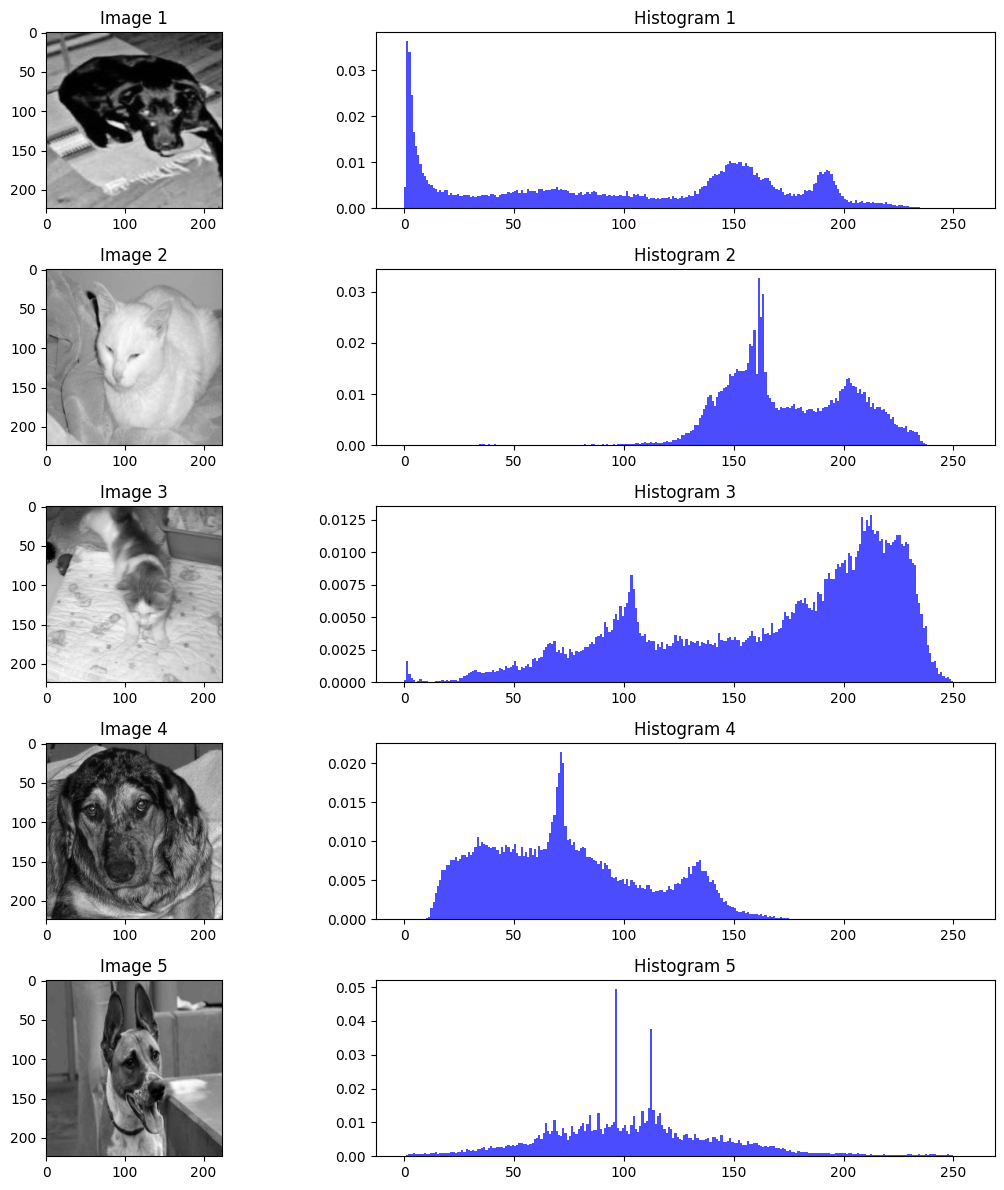

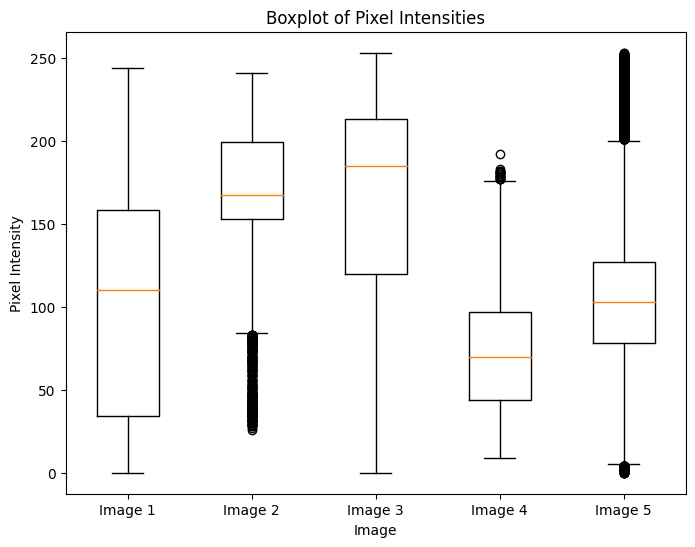

In [105]:
def load_images_and_preprocess(file_paths, train_path):
    images = []
    for file in file_paths[:5]:  # Chỉ tải 5 hình ảnh đầu tiên
        img_path = os.path.join(train_path, file)
        # Tải hình ảnh
        img = cv2.imread(img_path)
        if img is not None:
            # Thay đổi kích thước hình ảnh nếu cần (ví dụ, thay đổi kích thước thành 224x224)
            img_resized = cv2.resize(img, (224, 224))
            # Chuyển sang màu xám
            img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
            images.append(img_gray)
    return images

# Giả sử train_files và train_path được xác định trước đó
train_path = '/content/working/train/'
train_files = os.listdir(train_path)

# Tải và tiền xử lý chỉ 5 hình ảnh đầu tiên
images = load_images_and_preprocess(train_files, train_path)

# Vẽ biểu đồ cột cho 5 hình ảnh đầu tiên.
num_images_to_plot = len(images)
fig, axes = plt.subplots(num_images_to_plot, 2, figsize=(12, 12))

for i in range(num_images_to_plot):
    # Kế hoạch hình ảnh gốc
    axes[i, 0].imshow(images[i], cmap='gray')
    axes[i, 0].set_title(f'Image {i+1}')

    # Vẽ biểu đồ cột
    axes[i, 1].hist(images[i].ravel(), bins=256, range=(0, 256), density=True, color='b', alpha=0.7)
    axes[i, 1].set_title(f'Histogram {i+1}')

plt.tight_layout()
plt.show()

#Vẽ biểu đồ boxplot cho độ sáng của pixel trên 5 hình ảnh đầu tiên.plt.figure(figsize=(8, 6))
plt.boxplot([img.ravel() for img in images], labels=[f'Image {i+1}' for i in range(num_images_to_plot)])
plt.title('Boxplot of Pixel Intensities')
plt.xlabel('Image')
plt.ylabel('Pixel Intensity')
plt.show()

In [106]:
# Đường dẫn tới thư mục train
train_path = '/content/working/train/'

# Đường dẫn tới thư mục chó và mèo
dog_path = os.path.join(train_path, 'dogs')
cat_path = os.path.join(train_path, 'cats')

# Tạo thư mục nếu chúng không tồn tại.
os.makedirs(dog_path, exist_ok=True)
os.makedirs(cat_path, exist_ok=True)

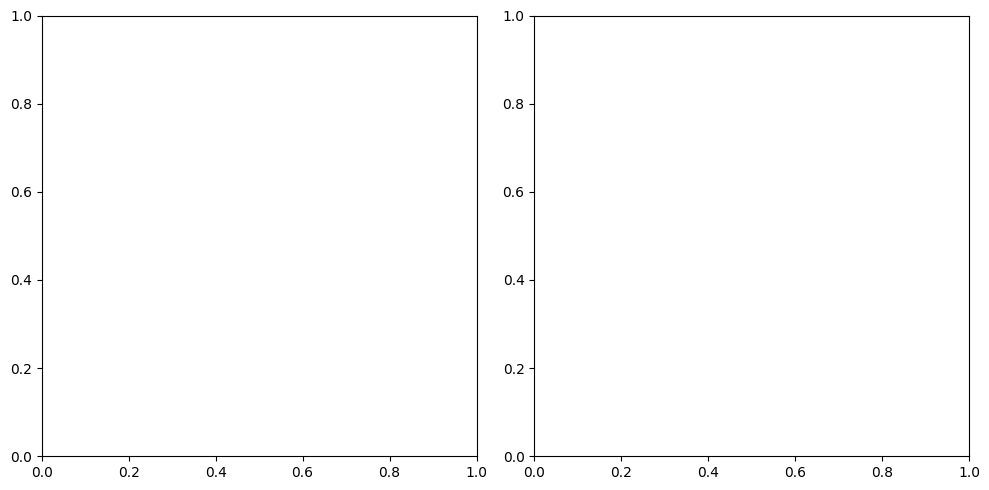

In [107]:
# Lấy danh sách tên file trong thư mục chó và mèo
dog_files = os.listdir(dog_path)
cat_files = os.listdir(cat_path)

# Lấy chỉ số của số lượng hình ảnh để hiển thị
num_images = 5
dog_files = dog_files[:num_images]
cat_files = cat_files[:num_images]

# Định nghĩa hàm để tính toán phân phối của các hình ảnh
def compute_distribution(image_files, image_path):
    distributions = []
    for file in image_files:
        img = Image.open(os.path.join(image_path, file))
        img = img.convert('L')  # Chuyển đổi sang ảnh xám nếu cần
        img_array = np.array(img).flatten()  # Chuyển đổi thành mảng 1 chiều
        distributions.append(img_array)
    return distributions

# Tính toán phân phối của chó và mèo
dog_distributions = compute_distribution(dog_files, dog_path)
cat_distributions = compute_distribution(cat_files, cat_path)

# Kiểm tra và hiển thị QQ-plot để so sánh phân phối
plt.figure(figsize=(10, 5))

# QQ-plot cho chó
plt.subplot(1, 2, 1)
if len(dog_distributions) > 0:
    stats.probplot(np.concatenate(dog_distributions), dist="norm", plot=plt)
    plt.title('QQ-plot - Dogs')

# QQ-plot cho mèo
plt.subplot(1, 2, 2)
if len(cat_distributions) > 0:
    stats.probplot(np.concatenate(cat_distributions), dist="norm", plot=plt)
    plt.title('QQ-plot - Cats')

plt.tight_layout()
plt.show()